<a href="https://colab.research.google.com/github/yuxuanzhuang/ENPMDA/blob/main/docs/source/examples/examples.ipynb" target="_parent"><img src=https://colab.research.google.com/assets/colab-badge.svg>

# ENPMDA Usage

In [1]:
import numpy as np

import dask
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=16, scheduler_port=8786,
                      memory_limit='auto')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 125.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 125.78 GiB
Comm: tcp://127.0.0.1:35883,Total threads: 2
Dashboard: http://127.0.0.1:43621/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:37939,


## Construct trajectory ensemble

In [2]:
from ENPMDA import MDDataFrame
from ENPMDA.preprocessing import TrajectoryEnsemble
from ENPMDATests.datafiles import (
    ensemble_ala_tpr,
    ensemble_ala_traj,
    ensemble_ala_top
)

In [3]:
# add tmp folder to path for testing
import tempfile
tempdir = tempfile.mkdtemp()

In [ ]:
traj_ensembles = TrajectoryEnsemble(ensemble_name=tempdir + '/test_ensemble',
                                    topology_list=ensemble_ala_top,
                                    trajectory_list=ensemble_ala_traj,
                                    tpr_list=ensemble_ala_tpr,
                                    updating=False,
                                    only_raw=False)

![dask task stream for trajectory preprocessing](./preprocessing_traj.png)

## Construct ENPMDA dataframe

In [5]:
md_dataframe = MDDataFrame(dataframe_name=tempdir + '/test_dataframe')

In [6]:
md_dataframe.add_traj_ensemble(traj_ensembles, npartitions=16)

Dask dataframe generated with 16 partitions


In [7]:
from ENPMDA.analysis import (
    DaskChunkMdanalysis,
    get_rmsd_init,
    get_backbonetorsion,
    get_atomic_position,
    get_protein_hydration,
)

The analysis can be a very simple wrapper of the default MDAnalysis analysis, e.g.

In [8]:
from MDAnalysis.analysis.rms import RMSD

class get_rmsd_init(DaskChunkMdanalysis):
    name = 'rmsd_to_init'

    def set_feature_info(self, universe):
        return ['rmsd_to_init']

    def run_analysis(self, universe, start, stop, step):

        name_backbone = universe.select_atoms('backbone')
        rmsd = RMSD(name_backbone, name_backbone).run(start, stop, step)
        return rmsd.results['rmsd'].T[2]

A sanity check will be performed to ensure that the analysis raises no error.

The parallel analysis will be actively done in the background so one can still coding in the notebook.

In [9]:
md_dataframe.add_analysis(get_rmsd_init)
md_dataframe.add_analysis(get_backbonetorsion)
md_dataframe.add_analysis(get_atomic_position)
md_dataframe.add_analysis(get_protein_hydration)

All the analysis can be run in parallel.

![dask task stream for analysis](./analysis_parallel.png)

In [10]:
md_dataframe.save('test_analysis')

In [11]:
md_dataframe.dataframe

,universe_protein,universe_system,system,traj_name,frame,traj_time,stride,rmsd_to_init,torsion,at_position,protein_hydration
0,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,0,0.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
1,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,1,2.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
2,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,2,4.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
3,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,3,6.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
4,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,4,8.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
...,...,...,...,...,...,...,...,...,...,...,...
163,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,16,32.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
164,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,17,34.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
165,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,18,36.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...
166,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,/tmp/tmpdx_iqfar/test_ensemble/_nethome_yzhuan...,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,19,38.0,1,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...,/tmp/tmpdx_iqfar/test_dataframe//analysis_resu...


All the features will be stored in `npy` files.

It can be accessed by `get_feature` function`

In [12]:
feature_dataframe = md_dataframe.get_feature([
                        'torsion',
                        'protein_hydration'
                        ])

In [13]:
feature_dataframe

,system,traj_name,frame,traj_time,0_phi_cos,0_phi_sin,1_psi_cos,1_psi_sin,protein_hydration
0,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,0,0.0,-0.972585,0.232546,-0.850531,-0.525925,89
1,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,1,2.0,-0.930982,0.365066,-0.182160,-0.983269,88
2,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,2,4.0,-0.921595,0.388153,-0.672957,-0.739681,93
3,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,3,6.0,-0.891143,0.453722,0.298339,-0.954460,94
4,0,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,4,8.0,-0.774034,0.633144,0.010315,-0.999947,102
...,...,...,...,...,...,...,...,...,...
163,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,16,32.0,-0.849980,0.526815,0.599313,-0.800515,97
164,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,17,34.0,-0.828825,0.559508,0.511923,-0.859032,102
165,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,18,36.0,-0.943376,0.331726,0.449359,-0.893351,91
166,7,/nethome/yzhuang/git_repo/ENPMDA/tests/ENPMDAT...,19,38.0,-0.335371,0.942086,0.311771,-0.950157,95


<AxesSubplot:xlabel='system', ylabel='protein_hydration'>

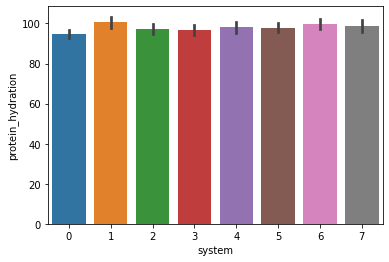

In [15]:
import seaborn as sns

sns.barplot(data=feature_dataframe,
             x='system',
             y='protein_hydration')